<a href="https://colab.research.google.com/github/makkimaki/GCIwinter2019_assignments/blob/master/Kaggle_titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"makkimaki04","key":"c721792c89dad7a07edd0dca08306bb1"}'}

In [0]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

In [7]:
import os
print(os.getcwd())

/content


In [9]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [10]:
!pip install kaggle

In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [13]:
!kaggle competitions download -c titanic

  0% 0.00/59.8k [00:00<?, ?B/s]
100% 59.8k/59.8k [00:00<00:00, 22.7MB/s]
  0% 0.00/3.18k [00:00<?, ?B/s]
100% 3.18k/3.18k [00:00<00:00, 2.90MB/s]
  0% 0.00/28.0k [00:00<?, ?B/s]
100% 28.0k/28.0k [00:00<00:00, 27.9MB/s]


In [63]:
path = os.getcwd()
print(path)
print(os.listdir())

/content
['.config', 'gender_submission.csv', '.kaggle', 'test.csv', 'train.csv', 'adc.json', 'sample_data']


In [0]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

import warnings 
warnings.filterwarnings("ignore")

In [0]:
df = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

data = pd.concat([df, df_test], sort=False)

In [47]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [65]:
data.info()
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 14 columns):
PassengerId    1309 non-null int64
Survived       891 non-null float64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1046 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1308 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
FamilySize     1309 non-null int64
IsAlone        1309 non-null int64
dtypes: float64(3), int64(6), object(5)
memory usage: 153.4+ KB


PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
FamilySize        0
IsAlone           0
dtype: int64

In [18]:
print("Training data shape: {}".format(df.shape))
print("Test data shape: {}".format(df_test.shape))

Training data shape: (891, 12)
Test data shape: (418, 11)


In [19]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [20]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [21]:
df_test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [39]:
age = pd.concat([df["Age"], df_test["Age"]])
fare = pd.concat([df["Fare"], df_test["Fare"]])

print("Mean of Age(Training set):", df["Age"].mean())
print("Mean of Age(Test set):", df_test["Age"].mean())

print("Median of Age(Training set):", df["Age"].median())
print("Median of Age(Test set):", df_test["Age"].median())

print("*****************************************************")
print("Mean of Age(concatenated data):", age.mean())
print("Median of Age(concatenated data):", age.median())


Mean of Age(Training set): 29.36158249158249
Mean of Age(Test set): 30.272590361445783
Median of Age(Training set): 28.0
Median of Age(Test set): 27.0
*****************************************************
Mean of Age(concatenated data): 29.608887980376124
Median of Age(concatenated data): 28.0


In [53]:
df["Age"].fillna(age.mean(), inplace=True)
df_test["Age"].fillna(age.mean(), inplace=True)
df["Fare"].fillna(fare.mean(), inplace=True)
df_test["Fare"].fillna(fare.mean(), inplace=True)

df.drop("Cabin", axis=1, inplace=True)
df_test.drop("Cabin", axis=1, inplace=True)

df_test.isnull().sum()

KeyError: ignored

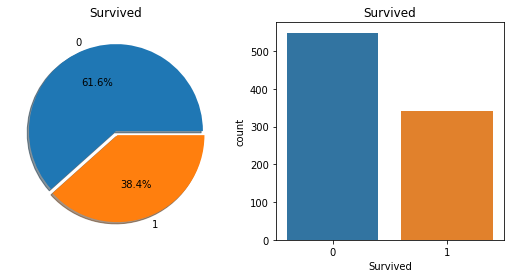

In [41]:
f, ax = plt.subplots(1, 2, figsize=(9, 4))
df["Survived"].value_counts().plot.pie(explode=[0, 0.05], autopct="%1.1f%%", ax=ax[0], shadow=True)
ax[0].set_title("Survived")
ax[0].set_ylabel("")
sns.countplot("Survived", data=df, ax=ax[1])
ax[1].set_title("Survived")
plt.show()

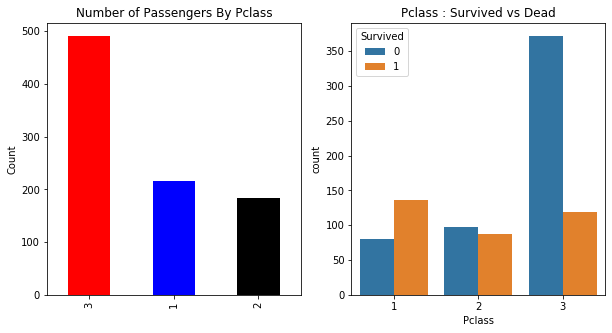

In [42]:
f, ax = plt.subplots(1,2,figsize=(10, 5))
df["Pclass"].value_counts().plot.bar(color=["r", "b", "k"], ax=ax[0])
ax[0].set_title("Number of Passengers By Pclass")
ax[0].set_ylabel("Count")
sns.countplot("Pclass", hue="Survived", data=df, ax=ax[1])
ax[1].set_title("Pclass : Survived vs Dead")
plt.show()

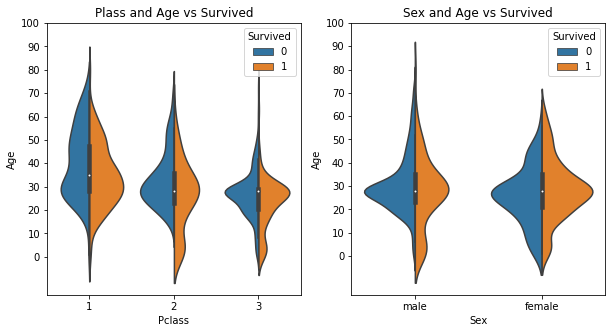

In [34]:
f, ax = plt.subplots(1,2,figsize=(10,5))
sns.violinplot("Pclass", "Age", hue="Survived", data=df, split=True, ax=ax[0])
ax[0].set_title("Plass and Age vs Survived")
ax[0].set_yticks(range(0, 110, 10))
sns.violinplot("Sex", "Age", hue="Survived", data=df, split=True, ax=ax[1])
ax[1].set_title("Sex and Age vs Survived")
ax[1].set_yticks(range(0, 110, 10))
plt.show()

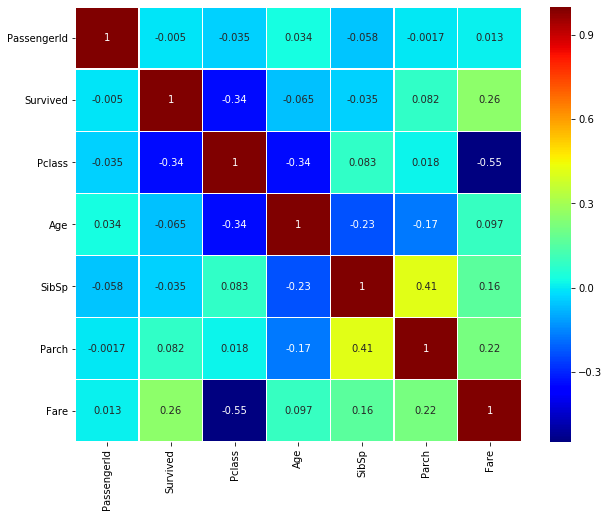

In [35]:
sns.heatmap(df.corr(), annot=True, cmap="jet", linewidth=0.2)
fig = plt.gcf()
fig.set_size_inches(10,8)
plt.show()

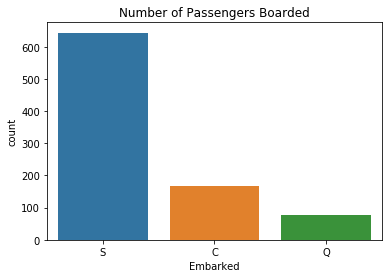

In [54]:
sns.countplot("Embarked", data=df)
plt.title("Number of Passengers Boarded")
plt.show()

In [58]:
df["Embarked"].fillna("S", inplace=True)
df_test["Embarked"].fillna("S", inplace=True)

df_test.isnull().sum()

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
FamilySize     0
dtype: int64

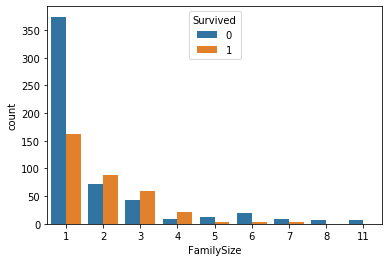

In [55]:
data["FamilySize"] = data["Parch"] + data["SibSp"] + 1
df["FamilySize"] = data["FamilySize"][:len(df)]
df_test["FamilySize"] = data["FamilySize"][len(df):]
sns.countplot(x="FamilySize", data=df, hue="Survived")

In [0]:
data["IsAlone"] = 0
data.loc[data["FamilySize"]==1, "IsAlone"] = 1
df["IsAlone"] = data["IsAlone"][:len(df)]
df_test["IsAlone"] = data["IsAlone"][len(df):]

df.drop("Name", axis=1, inplace=True)
df_test.drop("Name", axis=1, inplace=True)

df.drop("Ticket", axis=1, inplace=True)
df_test.drop("Ticket", axis=1, inplace=True)


In [70]:
df.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone
0,1,0,3,male,22.0,1,0,7.2500,S,2,0
1,2,1,1,female,38.0,1,0,71.2833,C,2,0
2,3,1,3,female,26.0,0,0,7.9250,S,1,1
3,4,1,1,female,35.0,1,0,53.1000,S,2,0
4,5,0,3,male,35.0,0,0,8.0500,S,1,1


In [71]:
df_test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone
0,892,3,male,34.5,0,0,7.8292,Q,1,1
1,893,3,female,47.0,1,0,7.0000,S,2,0
2,894,2,male,62.0,0,0,9.6875,Q,1,1
3,895,3,male,27.0,0,0,8.6625,S,1,1
4,896,3,female,22.0,1,1,12.2875,S,3,0


In [0]:
categorical_features = ["Embarked", "Sex", "Pclass"]

In [0]:
import lightgbm as lgb

X = df.iloc[:, 2:].values
y = df.iloc[:, 1].values

X_test = df_test.iloc[:, 1:].values

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [76]:
lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categorical_features)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train, categorical_feature=categorical_features)

params = {
    "objective": "binary"
}

model = lgb.train(params, lgb_train,
                  valid_sets=[lgb_train, lgb_eval],
                  verbose_eval=10,
                  num_boost_round=1200,
                  early_stopping_rounds=20)

y_pred = model.predict(X_test, num_iteration=model.best_iteration)

TypeError: ignored